# Kagome Spin Ice
***Walker Hendricks***
---
___
**Artificial Spin Ice: Boltzmann statistics vs. Experimental Observations**

Two PhD students, Student1 and Student2, from competing groups accidentally ran the same set
of experiments on thermalized artificial spin ice structures. The goal of both projects was to
thermally anneal finite-sized Kagome spin ice structures (1-ring, 2-ring and 3-ring structures) and
demonstrate the effectiveness of thermal annealing in achieving low-energy states in artificial spin
ice structures. To demonstrate that, the percentage of achieved low-energy states in these
experiments had to be compared to expected population values based on Boltzmann statistics. This
would also demonstrate thermal equilibrium.

Artificial spin ice structures consist of Ising-type nanomagnets: Each nanomagnet represents an
Ising-type magnetic moment
$$
m = M_s \times V
$$
that can only point in one of two directions along the
nanomagnet’s long axes. We assume all magnets to carry the same magnetic moments and we
can approximate each one as a magnetic point dipole. Therefore, the nanomagnets are dipolar
coupled with the interaction energy between each pair given by:
$$
E(\vec{r_1}, \vec{r_2}, \vec{m_1}, \vec{m_2}) = \frac{1}{\left|\vec{r}\right|^3} \left[\vec{m_1} \cdot \vec{m_2} - \frac{3}{\left|\vec{r}\right|^2}\left(\vec{m_1} \cdot \vec{r} \right) \left(\vec{m_2} \cdot \vec{r}\right) \right]
$$

The energy of a magnetic state achieved after thermal annealing can be calculated by averaging
of the sum of all pair-wise interactions over the overall number of nanomagnets within a building
block structure. The annealing experiments was performed at 𝑇 = 320 K and the assumed
saturation magnetization for each island is assumed to be 𝑀𝑠 = 3.75 × 105 A/m. The lattice
parameter 𝑎 = 500 nm can be used to calculate inter-nanomagnet distances 𝑟.

At the end of the experiments, both students reported to their PIs that the experiments were a
major success. However, their reported observations of low-energy states (example seen in
Figure 1b for a three-ring structure) differ significantly:

- Student1 reported 80% , 20% and 15% low-energy states achieved for single-, double- and triple-
ring structures respectively.
- Student2 reported 98-100% low-energy populations for all structures.

**TASK**: Determine which student’s results represent Boltzmann statistics more accurately?
___
**Useful literature on building block structures:**
1. [Thermally induced magnetic relaxation in building blocks of artificial kagome spin ice |
Phys. Rev. B](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.214405)
2. [Building blocks of an artificial kagome spin ice: Photoemission electron microscopy of
arrays of ferromagnetic islands | Phys. Rev. B](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.78.144402)
3. [Exploring hyper-cubic energy landscapes in thermally active finite artificial spin-ice
systems | Nature Physics](https://www.nature.com/articles/nphys2613)

# Strategy: The "Brute Force" Method

I thought about this for a while, and here's what I came up with:

The Boltzmann distribution is given by [[1]](https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_statistics):
$$
n_B = g_i e^{\beta(-E_i - \mu)} = \frac{N}{Z} g_i e^{-\beta E_i}
$$
where: 
- $g_i$ is the degeneracy of the $i$ th state
- $E_i$ is the energy of the $i$ th state
- $N$ is the total number of *Kagome systems* under consideration
- $Z$ is the partition function
- $\beta = k_B T$

Now, our goal is to find what the students got based on Boltzmann statistics: the percentage of states in the ground state. Thus, what we're looking for is
$$
\frac{n_B}{N} * 100\%
$$
where in this case $n_B$ is given for the ground state. The energies and respective degeneracies for these ground states are given in the Mengotti, 2008 paper (the second reference). This means we need to calculate
$$
\frac{1}{Z} g_0 e^{-\beta E_0}
$$
for the ground states of the 1-, 2-, and 3-ring structures. $g_0$ and $E_0$ are given by the paper:
| Rings | $E_0$ (J)  | $g_0$   | $N$ States |
|-------|------------|---------|------------|
| $1$   |$-2.35\times 10^{-18}$| $2$ | $2^6$ |
| $2$   |$-2.14\times 10^{-18}$| $2$ | $2^{11}$|
| $3$   |$-2.015\times 10^{-18}$| $12$ | $2^{15}$ |

What makes this problem so difficult to work on pen and paper is the partition function:
$$
Z = \sum_s g_s e^{-\beta E_s}
$$

My difficulty was figuring out a way to iterate over all the possible states and find their energies. Is there a nice form for this? I could not determine. Thus, I came to the realization that if I wanted to start making progress, I would need to go about this using a more brute force method.

## Imports
`numpy`: Since we're going to be dealing with vectors and vector operations, we really would like access to Numpy arrays. These can behave like vectors and are a lot easier to work with than native Python tuples/lists/sets/dictionaries.

`itertools`: How are we going to create all possible flips in calculating the partition function? You could nest as many `for` loops as you have dipoles flipped from the original configuration, but that would be computationally expensive. What you could do instead is create a 1-dimensional array of zeros and fill in as many ones as you have flipped dipoles (from your original configuration). Then you can create all combinations of this array and everywhere there's a one, flip the dipole. Then you can iterate over these arrays instead of many different `for` loops, leading to more efficient programming. Thus, we use `itertools.product`.

`copy`: For our functions, we want to apply changes to our configuration (such as removing magnets in our energy calculation); however, we don't *actually* want to remove them from our configuration. This is why we need to use Python's `copy` module: we can make a fresh copy of our configuration to edit as we wish. I've never copied a list of custom objects, so to avoid any potential mishaps we're going to use the `deepcopy()` function (as opposed to a shallow copy, `copy()`).

In [ ]:
import numpy as np
from itertools import product
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt

## Global Variables

In [2]:
# Calculating constants
ms = 3.75 * 10 ** 5
l = 470e-9   # m
w = 170e-9   # m
d = 5e-9     # m
V = l * w * d
m = ms * V
a = 500e-9

# Boltzmann constant
k = 1.380649e-23

# Temperature (given)
T = 320  # K

## `isingMag` Class

In the problem, we're told that these magnets are treated as "magnetic point dipoles". Thus, my goal here is to create a class to model each dipole. Then, I will create a method for flipping the magnet. This will be used to manually create all possible states.

In [3]:
class isingMag:
    '''
    A class that models the Ising point dipole magnets.
    '''
    def __init__(self, loc: np.ndarray, moment: np.ndarray):
        '''
        Parameters
        ----------
        loc     : ndarray
                    A Numpy array as a vector of the magnet's position.
        moment  : ndarray
                    A Numpy array as a vector of the magnet's magnetic moment
        '''
        self.loc = loc
        self.moment = moment


    def flip(self):
        '''
        Flips the orientation of the island's magnetic moment.
        '''
        self.moment = -1 * self.moment
        

    def draw(self, a: float, ax: matplotlib.axes._axes.Axes):
        '''
        Creates an arrow on a matplotlib plot to show the magnet's location and orientation.

        Parameters
        ----------
        a  : float
                The Kagome lattice parameter.
        ax  : matplotlib.axes._axes.Axes
                The matplotlib axes object on which the arrow will be plotted.
        '''
        l = 470e-9   # m
        w = 170e-9   # m

        arrow_length = l / a  # normalize to lattice parameter units
        moment_unit = self.moment / np.linalg.norm(self.moment)
        # Rescaling arrow to appropriate position (tail needs to move back l/2 along the arrow)
        theta = np.arctan2(self.moment[1], self.moment[0])
        x = self.loc[0] / a - (arrow_length / 2) * moment_unit[0]
        y = self.loc[1] / a - (arrow_length / 2) * moment_unit[1]

        # Rescaling arrow to appropriate length (needs to have magnitude of l)
        u, v = arrow_length * moment_unit
        
        # Plotting the arrow
        ax.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, width=0.01, color='black')

## Functions

### `build_lattice()` Function
We also need to calculate the positions of each of the magnets in the lattice. Since we're only dealing with specific ring cases (and not arbitrary numbers of rings), this is fairly straightforward. The general operating procedure for this function is as follows:
1. Set the first hexagon's center at zero.
2. We will start generating Ising magnet structures at $\theta = 0$ or $(x, y) = (a, 0)$.
3. Generate the Ising magnets following at coordinates following the parametric form $(x, y) = (a\cos{\theta}, a\sin{\theta})$.
4. Vary $\theta$ in $360\degree / 6 = 60\degree$ increments.
5. Once the first hexagon is created, move the center of the next hexagon to the position $(x, y) = (2a, 0)$.
6. Repeat steps 1-4 with this new center. Note that the new $(x, y)$ coordinates in step 3 will have $x$ and $y$ shifts based on the new location of the hexagon's origin.
7. Repeat steps 5-6. Move the center of the new hexagon using the parametric form $(x, y) = (2a\cos{\theta}, 2a\sin{\theta})$

We will need several gates/checks for this function to ensure it runs properly:
1. To ensure there is no double counting, before an Ising magnet is created at a point, we need an `if` statement that checks whether there is a magnet at that position. We can check to the nearest whole number or first decimal point. If there is, 
2. Before moving on from the first ring, we should have an `if` statement checking whether the number of rings argument passed to the `build_lattice()` function is greater than 1. For the three ring state, we should check if it's greater than 2 (or `==3`).

### `energy()` Function
We will need to calculate the energy between all of the different magnets. Thus, I create a function here to do this for the entire system. In general, the operating process of the funciton is:
1. Take a list of all of the magnets in the system.
2. Select the first magnet, and calculate the energies between this magnet and all the other magnets.
3. Remove this magnet from the list.
4. Repeat with the second magnet.
5. Sum all of the total energies along the way.


### `Z_lattice()` Function
Next, we will need to calculate the partition function for the system of interest. This was where I got hung up trying to find a nice form and decided to do this with brute force. It will rely on the `energy()` function to calculate the energy of each state. The general operating procedure for this function is as follows:
1. If we start with a configuration of $n$ magnets, we can have multiple scenarios where we flip $1, 2, ..., n$ of them. To account for all possible states in a more computationally efficient way (as opposed to a series of $1, 2, ..., n$ different nested `for` loops), we'll map which magnets get flipped from an array of $1$s and $0$s:
    1. Create an empty Numpy array of the size of the total number of configurations ($2^n$).
    2. Create a `numpy.zeros()` array of 1 dimension and length $n$. Call this the "outer array"
    3. Change one of the indices to a $1$.
    4. Use the `itertools.product()` function to create all possible arrangements of this array. Store them all in the outer array.
    5. Repeat steps 2-4, but let the number of $1$s you add change with the number of magnets you intend to flip ($1, 2, ..., n$).
3. Start with the initial state given and calculate its energy.
4. Use this to calculate the Boltzmann factor, and start a continuous sum going for the partition function.
5. Iterate over all Numpy arrays in the outer array containing ones and zeros:
    1. Wherever there is a $1$, flip that magnet.
    2. Calculate the energy of the state.
    3. Calculate the Boltzmann factor for the state.
    4. Add this Boltzmann factor to the ongoing sum for the partition function.
    5. Repeat until all arrays in the outer array have been iterated over.

In [4]:
def build_lattice(num_rings: int, m: float, a: float) -> list:
    '''
    Generates the lattice structure with identical Ising magnets at each point in the lattice.

    Parameters
    ----------
    num_rings   : int
                    The number of rings to construct the lattice out of (1, 2, or 3).
    m           : float
                    The magnitude of the magnetic moment of the magnets.
    a           : float
                    The lattice parameter; the distance from an edge to the center of the hexagon.

    Returns
    -------
    config      : list
                    The list containing all of the Ising magnets at the correct locations.
    '''
    theta_vals = np.linspace(0, 360, 7)[:-1]  # Avoid duplicate point at 360°
    config = []
    locs = []

    # Define origins for each ring
    origins = [np.array([0, 0])]
    if num_rings > 1:
        origins.append(2 * a * np.array([np.cos(np.radians(0)), np.sin(np.radians(0))]))
    if num_rings == 3:
        origins.append(2 * a * np.array([np.cos(np.radians(60)), np.sin(np.radians(60))]))

    for origin in origins:
        for theta in theta_vals:
            # Position
            x = a * np.cos(np.radians(theta)) + origin[0]
            y = a * np.sin(np.radians(theta)) + origin[1]
            loc = np.array([x, y])

            # Check for duplicate
            if any(np.allclose(loc, existing) for existing in locs):
                continue

            locs.append(loc)

            # Moment vector perpendicular to position vector (hexagonal edge-aligned)
            rel_loc = loc - origin
            moment_init = np.array([-rel_loc[1], rel_loc[0]])
            moment = m * moment_init / np.linalg.norm(moment_init)

            config.append(isingMag(loc, moment))

    return config

def energy(config: list, combo: tuple) -> float:
    '''
    Calculates the energy of a configuration of Ising magnets.

    Parameters
    ----------
    config     : list
                 The list containing all of the Ising magnets.
    combo      : tuple
                 The particular combination of flip operations on the starting state.

    Returns
    -------
    E          : float
                 The energy of the given configuration.
    '''
    local_config = deepcopy(config)  # Create a deep copy to avoid modifying the original configuration [cite: 12]

    # Making the appropriate flips based on the 'combo'
    for i, flip in enumerate(combo):  # Iterate through each magnet and its corresponding flip instruction
        if flip:  # If 'flip' is True (or 1), flip the magnet
            local_config[i].flip()  # Call the 'flip' method of the isingMag object [cite: 3, 4]

    E = 0 
    # Iterate through all magnets except the last one
    for i in range(len(local_config) - 1):
        # Iterate through the remaining magnets to avoid double-counting pairs
        for j in range(i + 1, len(local_config)):
            # Distance vector
            r = local_config[j].loc - local_config[i].loc
            r_mag = np.linalg.norm(r)
            # Calculate the interaction energy
            E += (1 / (r_mag**3)) * (
                np.dot(local_config[i].moment, local_config[j].moment)
                - (3 / (r_mag**2))
                * np.dot(local_config[i].moment, r)
                * np.dot(local_config[j].moment, r)
            )

    return E

def Z_lattice(config: list, T: float, scale_factor: float =1e18) -> float:
    '''
    Calculates the partition function for the Kagome lattice.

    Parameters
    ----------
    config        : list
                    The configuration of Ising magnets of the Kagome lattice.
    T             : float
                    Temperature of the system, in K.
    scale_factor  : float
                    How much the energy is scaled by to keep values more calculable for Python.
    Returns
    -------
    Z             : float
                    The partition function for the lattice.
    '''
    flip_patterns = list(product([0, 1], repeat=len(config)))
    energies = np.array([energy(deepcopy(config), combo) for combo in flip_patterns])

    E_min = np.min(energies)
    E_max = np.max(energies)
    
    # 1. Shift energies
    energies_shifted = energies - E_min
    
    # 2. Scale energies (but ensure the max isn't too large relative to kT)
    target_max = 100  # A target maximum energy (after scaling)
    beta = 1 / (k * T)
    
    # Calculate a scaling factor to bring E_max close to target_max
    scale_factor = min(scale_factor, target_max / (beta * (E_max - E_min) + 1e-10))  # Avoid division by zero
    energies_scaled = energies_shifted * scale_factor
    beta_scaled = beta / scale_factor
    
    # Log-sum-exp
    logZ = np.log(np.sum(np.exp(-beta_scaled * energies_scaled)))
    Z = np.exp(logZ)

    return Z

A note here: I've reformatted some of my functions because I kept getting `inf` for the partition function. This is because the energy scales were too small. I've reshifted so that the ground state is 0 energy, and I take the log of the partition function to make the size of the calculated values smaller.

## Test Plotting
Before we get started, we really want to make sure our systems are generating properly. This is why I implemented the `draw()` method for the island object. Below, I check to see if they are actually forming the correct geometries we're aiming for.

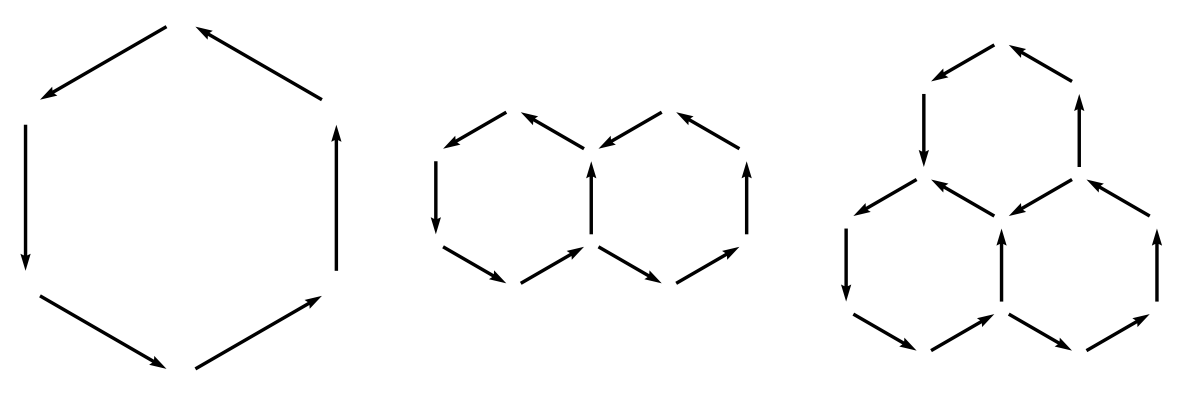

In [5]:
# Creating configurations (1, 2, and 3-rings, respectively)
config1 = build_lattice(1, m, a)
config2 = build_lattice(2, m, a)
config3 = build_lattice(3, m, a)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = 0
for config in (config1, config2, config3):
    for mag in config:
        mag.draw(a, axes[ax])
    axes[ax].set_axis_off()
    axes[ax].set_aspect('equal')
    ax += 1

This looks good! We're not necessarily needing to create the lowest energy states here following the ice rules; we're really just trying to get an initial state.

## Final Occupancies

In [6]:
# Ground state values (we've shifted E to 0 by design)
E0 = 0  # J

g0_1 = 2
g0_2 = 2
g0_3 = 12

# Partition functions
Z1 = Z_lattice(config1, T)
Z2 = Z_lattice(config2, T)
Z3 = Z_lattice(config3, T)

# Final occupancies (%)
frac1 = 1/Z1 * g0_1 * np.exp(-E0 / (k*T)) * 100
frac2 = 1/Z2 * g0_2 * np.exp(-E0 / (k*T)) * 100
frac3 = 1/Z3 * g0_3 * np.exp(-E0 / (k*T)) * 100

print(f"For the single-ring states, we expect {frac1:.2f}% in the ground state.")
print(f"For the two-ring states, we expect {frac2:.2f}% in the ground state.")
print(f"For the three-ring states, we expect {frac3:.2f}% in the ground state.")

For the single-ring states, we expect 100.00% in the ground state.
For the two-ring states, we expect 100.00% in the ground state.
For the three-ring states, we expect 100.00% in the ground state.


Given that my code is completely accurate with no mistakes, Student 2's results match Boltzmann statistics.